# General functions

In [ ]:
import wandb
from pprint import pprint

api = wandb.Api()

def get_metrics(game, step_threshold, run_name):
    step_threshold //= 20

    game_metrics = ["win_rate", "loss_rate", "draw_rate"] if game == "rock-paper-scissors" else \
                   ["normalized_earnings", "normalized_earnings (*32)"] if game == "bertrand-competition" else \
                   ["bargaining_power", "bargaining_power (*32)", "deal (%)", "deal (%) (*32)"] if game == "size-prize-bargaining-game" else None
    
    general_metrics = ["state_relative_performance", "leverage_opportunity", "internal_state_evaluation", "reward", "normalized_relative_advantage"]

    game_metrics = [f"eval/{metric}" for metric in game_metrics]
    general_metrics = [f"eval/{metric}" for metric in general_metrics]

    run = api.run("victor-conchello/" + game + "/" + run_name)

    game_df = run.history(keys=game_metrics)
    print(len(game_df), step_threshold, sum(game_df.index >= step_threshold))
    print(len(game_df) / sum(game_df.index >= step_threshold))
    game_df = game_df[game_df.index >= step_threshold]
    general_df = run.history(keys=general_metrics)
    general_df = general_df[general_df.index >= step_threshold]

    general_df['eval/internal_state_evaluation'] = - general_df['eval/internal_state_evaluation']
    if game == "bertrand-competition": game_df['eval/normalized_earnings'] = 32*game_df['eval/normalized_earnings']/5 if 'eval/normalized_earnings' in game_df else game_df['eval/normalized_earnings (*32)']/5
    elif game == "size-prize-bargaining-game":
        game_df['eval/bargaining_power'] = 32*game_df['eval/bargaining_power'] if 'eval/bargaining_power' in game_df else game_df['eval/bargaining_power (*32)']
        game_df['eval/deal (%)'] = 32*game_df['eval/deal (%)'] if 'eval/deal (%)' in game_df else game_df['eval/deal (%) (*32)']

    rename_dict = {
        "eval/state_relative_performance": "SRP",
        "eval/leverage_opportunity": "LO",
        "eval/internal_state_evaluation": "ISE",
        "eval/reward": "R", 
        "eval/normalized_relative_advantage": "NRA",
        "eval/normalized_earnings" : "NE",
        "eval/bargaining_power" : "BP",
    }

    return {(rename_dict[metric] if metric in rename_dict else metric): general_df[metric].mean() for metric in general_metrics}, \
           {(rename_dict[metric] if metric in rename_dict else metric): game_df[metric].mean() for metric in game_metrics}

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def spider_plot(data, ax, label=None, color=None, y_lim = [0,1]):
    # Extract keys and values
    categories = ['R', 'NRA', 'ISE', 'SRP', 'LO', "NE", "BP"]
    values = [data[c] for c in categories if c in data]
    values += values[:1] # Repeat the first value to close the circle

    N = len(categories)

    # Angles for each axis
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    # Draw the outline
    color = {"color":color} if color is not None else {}
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=label, **color)
    ax.fill(angles, values, alpha=0.25, **color)

    # Add category labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.tick_params(axis='x', labelsize=12)

    ax.set_theta_offset(np.pi / 2)      # Start at 12 o'clock (90 degrees)
    ax.set_theta_direction(-1)
    ax.set_yticklabels([])
    if y_lim is not None: ax.set_ylim(*y_lim)

In [13]:
def round_with_sum_constraint(values, decimals=2):
    scale = 10**decimals
    scaled = [v * scale for v in values]

    # Floor all values and keep track of remainders
    floored = [int(v) for v in scaled]
    remainders = [v - f for v, f in zip(scaled, floored)]

    # Calculate how much we need to adjust to make the sum correct
    total = int(round(sum(scaled)))
    current_sum = sum(floored)
    difference = total - current_sum

    # Distribute the remaining units to the largest remainders
    indices = sorted(range(len(remainders)), key=lambda i: remainders[i], reverse=True)
    for i in indices[:difference]:
        floored[i] += 1

    # Scale back down
    return [f / scale for f in floored]

In [14]:
def wdr_plot(win, draw, lose, ax, x_pos=0, show_legend=True):
    heights = round_with_sum_constraint([win, draw, lose])
    bottoms = [lose+draw, lose, 0]
    colors = ['limegreen', 'lightgray', 'red']
    labels = ['Win', 'Draw', 'Lose']

    for h, b, c, l in zip(heights, bottoms, colors, labels):
        ax.bar(x_pos, h, bottom=b, color=c, edgecolor='black', width=0.7, label=l if show_legend else None)
        ax.text(x_pos, b + h/2, f'{int(h*100)}%', ha='center', va='center', fontsize=10)

    ax.set_ylim(-0.005, 1.005)
    ax.set_yticks([x/10 for x in range(0, 11, 1)])
    ax.tick_params(axis='y', labelsize=7.5)

    # Hide axis
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)

In [15]:
### Rock-Paper-Scissors values ###
min_val = {'ISE' : -1.5, 'LO': 0, 'NRA': -1, 'R': 0, 'SRP': 0}
max_val = {'ISE' : 0, 'LO': 2, 'NRA': 1, 'R': 2, 'SRP': 1}

### Bertrand Competition values ###
min_val = {'ISE' : -1.5, 'LO': 0, 'NRA': -1, 'R': 0, 'SRP': 0, 'NE': -0.3}
max_val = {'ISE' : 0, 'LO': 15_000, 'NRA': 1, 'R': 50_000, 'SRP': 1, 'NE': 0.5}


def normalize(data):
    return {
        key: max(0,(data[key] - min_val[key]) / (max_val[key] - min_val[key]))
        for key in data
    }

# Rock-Paper-Scissors

In [6]:
def plot_rps_runs(runs, wspace=0.4):
    N = len(runs)

    fig = plt.figure(figsize=(5 + N, 3))
    gs = fig.add_gridspec(1, 2, width_ratios=[5, N], wspace=wspace)
    ax1 = fig.add_subplot(gs[0, 0], polar=True)
    ax2 = fig.add_subplot(gs[0, 1])

    game = "rock-paper-scissors"
    for i, r in enumerate(runs):
        if len(r) == 3: (run_name, step_threshold, label), color = r, None
        else:            run_name, step_threshold, label , color = r

        general_metrics, game_metrics = get_metrics(game, step_threshold, run_name)
        print(label, ':')
        pprint(general_metrics)
        pprint(game_metrics)
        print()

        spider_plot(normalize(general_metrics), ax1, label=label, color=color)
        wdr_plot(game_metrics['eval/win_rate'], game_metrics['eval/draw_rate'], game_metrics['eval/loss_rate'], ax2, x_pos=i, show_legend=i == 0)

    ax1.legend(loc='center left', bbox_to_anchor=(0.8, 0.95), frameon=False)

    ax2.set_xlim(-0.5, N - 0.5)
    ax2.set_xticks(range(N))
    ax2.set_xticklabels([x[2] for x in runs], fontsize=9, rotation=45)
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

    plt.show()

Untrained :
{'ISE': np.float64(-0.7672038855775534),
 'LO': np.float64(1.1834402188793414),
 'NRA': np.float64(-0.3413562979923275),
 'R': np.float64(0.6066176470588235),
 'SRP': np.float64(0.5409690301427668)}
{'eval/draw_rate': np.float64(0.33639705882352944),
 'eval/loss_rate': np.float64(0.49080882352941174),
 'eval/win_rate': np.float64(0.17279411764705882)}

Base :
{'ISE': np.float64(-0.8116567592043605),
 'LO': np.float64(1.1464305381385085),
 'NRA': np.float64(0.10598438300051202),
 'R': np.float64(1.0972222222222223),
 'SRP': np.float64(0.5408859313595917)}
{'eval/draw_rate': np.float64(0.26944444444444443),
 'eval/loss_rate': np.float64(0.3138888888888889),
 'eval/win_rate': np.float64(0.4166666666666667)}



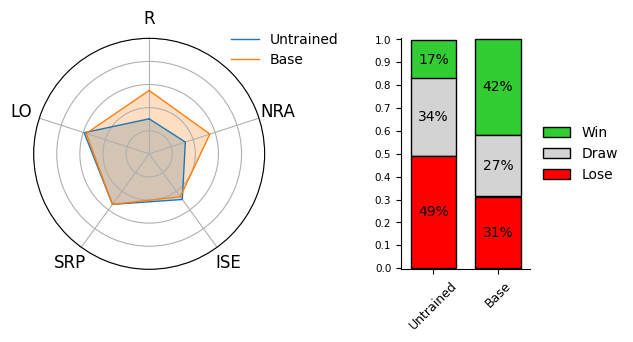

In [7]:
plot_rps_runs([
    ("noPaper-baseline-3", 0, "Untrained"),
    ("noPaper-first_2-2", 2000, "Base"),
])

Base :
{'ISE': np.float64(-0.8116567592043605),
 'LO': np.float64(1.1464305381385085),
 'NRA': np.float64(0.10598438300051202),
 'R': np.float64(1.0972222222222223),
 'SRP': np.float64(0.5408859313595917)}
{'eval/draw_rate': np.float64(0.26944444444444443),
 'eval/loss_rate': np.float64(0.3138888888888889),
 'eval/win_rate': np.float64(0.4166666666666667)}

Beta=1e-2 :
{'ISE': np.float64(-2.706496660128154),
 'LO': np.float64(1.11551635628595),
 'NRA': np.float64(0.2122448979591837),
 'R': np.float64(1.1964285714285714),
 'SRP': np.float64(0.18146592503059242)}
{'eval/draw_rate': np.float64(0.15625),
 'eval/loss_rate': np.float64(0.32142857142857145),
 'eval/win_rate': np.float64(0.5223214285714286)}

Beta=1e-3 :
{'ISE': np.float64(-3.527407408467368),
 'LO': np.float64(1.1162472518571973),
 'NRA': np.float64(0.30940372409822925),
 'R': np.float64(1.3033333333333332),
 'SRP': np.float64(7.665890884093573e-07)}
{'eval/draw_rate': np.float64(0.14666666666666667),
 'eval/loss_rate': np.fl

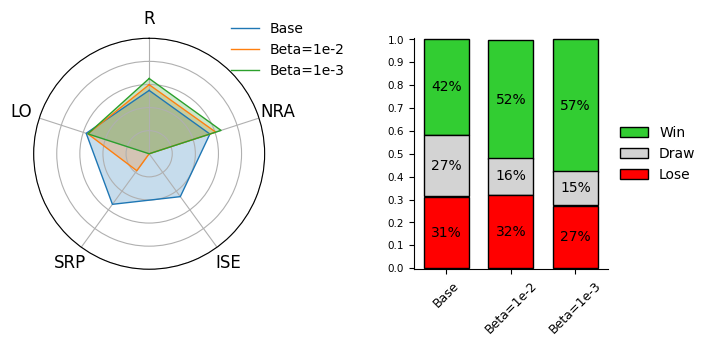

Base :
{'ISE': np.float64(-0.8116567592043605),
 'LO': np.float64(1.1464305381385085),
 'NRA': np.float64(0.10598438300051202),
 'R': np.float64(1.0972222222222223),
 'SRP': np.float64(0.5408859313595917)}
{'eval/draw_rate': np.float64(0.26944444444444443),
 'eval/loss_rate': np.float64(0.3138888888888889),
 'eval/win_rate': np.float64(0.4166666666666667)}

Entropy term :
{'ISE': np.float64(-0.8283148588600829),
 'LO': np.float64(1.2109313715920569),
 'NRA': np.float64(-0.20649372749974232),
 'R': np.float64(0.77),
 'SRP': np.float64(0.5203477144709538)}
{'eval/draw_rate': np.float64(0.46208333333333335),
 'eval/loss_rate': np.float64(0.3720833333333333),
 'eval/win_rate': np.float64(0.16583333333333333)}



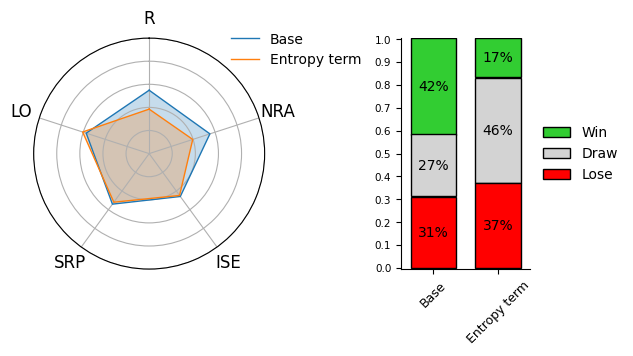

In [8]:
plot_rps_runs([
    ("noPaper-first_2-2", 2000, "Base"),
    ("noPaper_beta-1e-2-0", 500, "Beta=1e-2"),
    ("noPaper_beta-1e-3-0", 1500, "Beta=1e-3"),
])

plot_rps_runs([
    ("noPaper-first_2-2", 2000, "Base"),
    ("noPaper_entropyLoss-1e-1-5", 1500, "Entropy term")
])

r=8 :
{'ISE': np.float64(-0.7430921639984186),
 'LO': np.float64(1.2066085425891646),
 'NRA': np.float64(-0.20861937995537194),
 'R': np.float64(0.7738970588235294),
 'SRP': np.float64(0.5635727547944867)}
{'eval/draw_rate': np.float64(0.5055147058823529),
 'eval/loss_rate': np.float64(0.35294117647058826),
 'eval/win_rate': np.float64(0.14154411764705882)}

r=32 (Base) :
{'ISE': np.float64(-0.8116567592043605),
 'LO': np.float64(1.1464305381385085),
 'NRA': np.float64(0.10598438300051202),
 'R': np.float64(1.0972222222222223),
 'SRP': np.float64(0.5408859313595917)}
{'eval/draw_rate': np.float64(0.26944444444444443),
 'eval/loss_rate': np.float64(0.3138888888888889),
 'eval/win_rate': np.float64(0.4166666666666667)}

r=64 :
{'ISE': np.float64(-0.6112084831896509),
 'LO': np.float64(1.1518615715300806),
 'NRA': np.float64(0.1488690476190476),
 'R': np.float64(1.1410714285714285),
 'SRP': np.float64(0.258941749472)}
{'eval/draw_rate': np.float64(0.23392857142857143),
 'eval/loss_rate': 

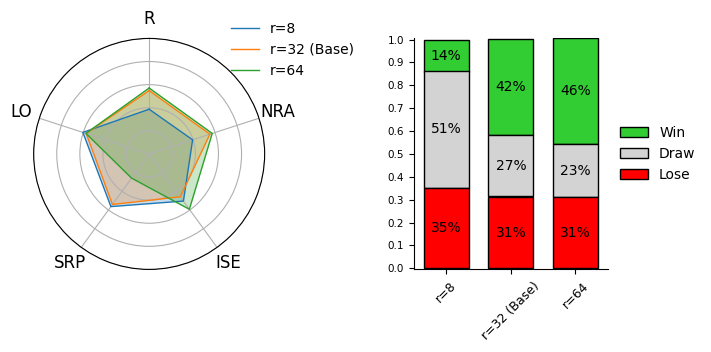

In [9]:
plot_rps_runs([
    ("noPaper-lora8-0", 2000, "r=8"),
    ("noPaper-first_2-2", 2000, "r=32 (Base)"),
    ("noPaper-lora64-0", 2200, "r=64")
])

Base :
{'ISE': np.float64(-0.8116567592043605),
 'LO': np.float64(1.1464305381385085),
 'NRA': np.float64(0.10598438300051202),
 'R': np.float64(1.0972222222222223),
 'SRP': np.float64(0.5408859313595917)}
{'eval/draw_rate': np.float64(0.26944444444444443),
 'eval/loss_rate': np.float64(0.3138888888888889),
 'eval/win_rate': np.float64(0.4166666666666667)}

ISE-reward :
{'ISE': np.float64(-0.7027680759443761),
 'LO': np.float64(1.1996083486824582),
 'NRA': np.float64(-0.19699988431660567),
 'R': np.float64(0.7892219387755102),
 'SRP': np.float64(0.5710867710083408)}
{'eval/draw_rate': np.float64(0.4610969387755102),
 'eval/loss_rate': np.float64(0.36830357142857145),
 'eval/win_rate': np.float64(0.17059948979591838)}

LO-reward :
{'ISE': np.float64(-0.846351129958738),
 'LO': np.float64(1.5008565646688232),
 'NRA': np.float64(0.4088611111111112),
 'R': np.float64(1.396875),
 'SRP': np.float64(0.5492676474036075)}
{'eval/draw_rate': np.float64(0.28125),
 'eval/loss_rate': np.float64(0.1

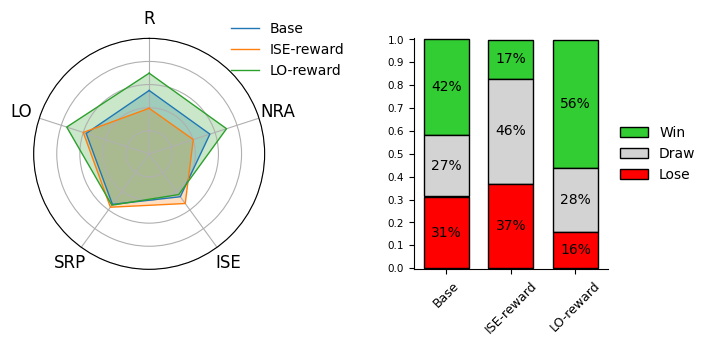

In [10]:
plot_rps_runs([
    ("noPaper-first_2-2", 2000, "Base"),
    ("noPaper-internalStateEvaluation_reward-2-0", 0, "ISE-reward"),
    ("noPaper_levOp-reward-2", 2000, "LO-reward"),
])

LO-reward :
{'ISE': np.float64(-0.846351129958738),
 'LO': np.float64(1.5008565646688232),
 'NRA': np.float64(0.4088611111111112),
 'R': np.float64(1.396875),
 'SRP': np.float64(0.5492676474036075)}
{'eval/draw_rate': np.float64(0.28125),
 'eval/loss_rate': np.float64(0.158125),
 'eval/win_rate': np.float64(0.560625)}

+ Natural-reward :
{'ISE': np.float64(-0.9235471337925305),
 'LO': np.float64(1.247752068623713),
 'NRA': np.float64(-0.19121599018733274),
 'R': np.float64(0.7935855263157895),
 'SRP': np.float64(0.5146668269747344)}
{'eval/draw_rate': np.float64(0.4629934210526316),
 'eval/loss_rate': np.float64(0.3651315789473684),
 'eval/win_rate': np.float64(0.171875)}

+ LO-scaling :
{'ISE': np.float64(-0.9578882559964276),
 'LO': np.float64(1.5344061483559703),
 'NRA': np.float64(0.33693544861447405),
 'R': np.float64(1.31484375),
 'SRP': np.float64(0.3925505185161439)}
{'eval/draw_rate': np.float64(0.2515625),
 'eval/loss_rate': np.float64(0.21171875),
 'eval/win_rate': np.float6

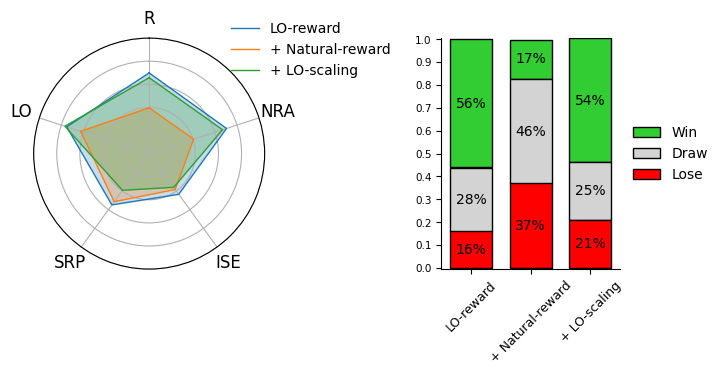

In [11]:
plot_rps_runs([
    ("noPaper_levOp-reward-2", 2000, "LO-reward"),
    ("noPaper_naturalness-reward-1e-1-3", 2000, "+ Natural-reward"),
    ("noPaper_weights-10-1e-1-1", 2200, "+ LO-scaling")
], wspace=0.6)

Previous shaping :
{'ISE': np.float64(-0.9578882559964276),
 'LO': np.float64(1.5344061483559703),
 'NRA': np.float64(0.33693544861447405),
 'R': np.float64(1.31484375),
 'SRP': np.float64(0.3925505185161439)}
{'eval/draw_rate': np.float64(0.2515625),
 'eval/loss_rate': np.float64(0.21171875),
 'eval/win_rate': np.float64(0.53671875)}

Binary Naturalness :
{'ISE': np.float64(-0.9484188626202996),
 'LO': np.float64(1.5541790888266924),
 'NRA': np.float64(0.4089599139090664),
 'R': np.float64(1.3875),
 'SRP': np.float64(0.440569592778431)}
{'eval/draw_rate': np.float64(0.260625),
 'eval/loss_rate': np.float64(0.170625),
 'eval/win_rate': np.float64(0.56875)}



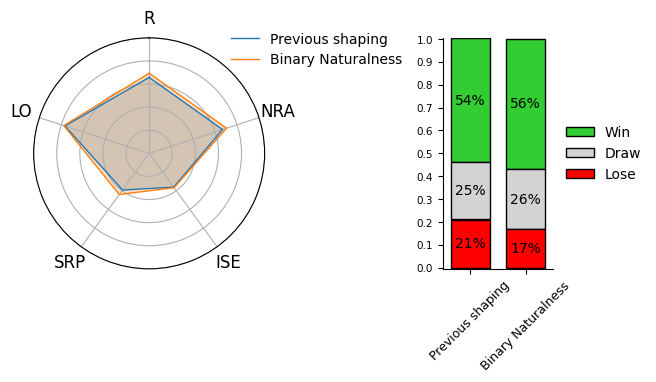

In [12]:
plot_rps_runs([
    ("noPaper_weights-10-1e-1-1", 2200, "Previous shaping"),
    ("noPaper_weights-10-1e-1_naturalness-threshold-07-0", 2000, "Binary Naturalness"),
], wspace=0.8)

Untrained :
{'ISE': np.float64(-0.5628815112503355),
 'LO': np.float64(1.5835749538663322),
 'NRA': np.float64(0.048268270767392076),
 'R': np.float64(1.0044642857142858),
 'SRP': np.float64(0.5224984558113305)}
{'eval/draw_rate': np.float64(0.40625),
 'eval/loss_rate': np.float64(0.28125),
 'eval/win_rate': np.float64(0.3125)}

GRPO :
{'ISE': np.float64(-0.6118782198568706),
 'LO': np.float64(1.505635497816358),
 'NRA': np.float64(0.6890816215967913),
 'R': np.float64(1.632421875),
 'SRP': np.float64(0.8419964250345977)}
{'eval/draw_rate': np.float64(0.183984375),
 'eval/loss_rate': np.float64(0.082421875),
 'eval/win_rate': np.float64(0.73359375)}



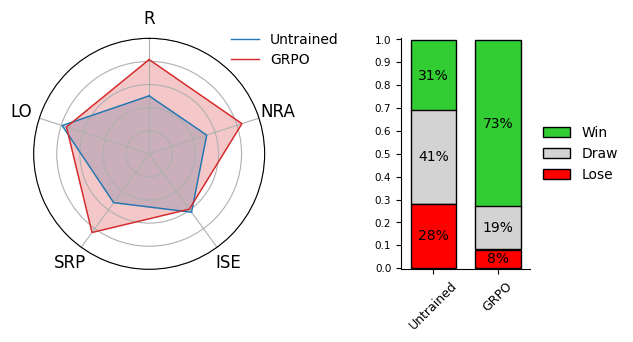

In [23]:
plot_rps_runs([
    ("RPS-baseline-0", 0, "Untrained", "#1f77b4"),
    ("grpo_final-2", 1000, "GRPO", "#d62728"),
])

Untrained :
{'ISE': np.float64(-0.5628815112503355),
 'LO': np.float64(1.5835749538663322),
 'NRA': np.float64(0.048268270767392076),
 'R': np.float64(1.0044642857142858),
 'SRP': np.float64(0.5224984558113305)}
{'eval/draw_rate': np.float64(0.40625),
 'eval/loss_rate': np.float64(0.28125),
 'eval/win_rate': np.float64(0.3125)}

DPO-perms :
{'ISE': np.float64(-0.5828645773828224),
 'LO': np.float64(1.5240358007884198),
 'NRA': np.float64(0.6512602944449467),
 'R': np.float64(1.6052791262135921),
 'SRP': np.float64(0.873494275201169)}
{'eval/draw_rate': np.float64(0.17930825242718446),
 'eval/loss_rate': np.float64(0.09739077669902912),
 'eval/win_rate': np.float64(0.7233009708737864)}

DPO-pairs :
{'ISE': np.float64(-0.5532132647426422),
 'LO': np.float64(1.5447001692682385),
 'NRA': np.float64(0.6288495752303211),
 'R': np.float64(1.5634282178217822),
 'SRP': np.float64(0.877182062616112)}
{'eval/draw_rate': np.float64(0.1791460396039604),
 'eval/loss_rate': np.float64(0.1132425742574

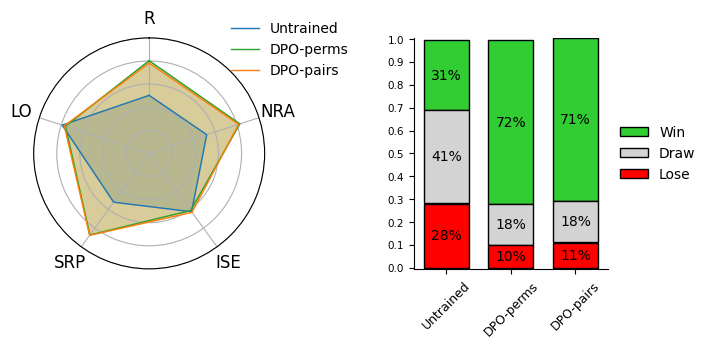

In [ ]:
plot_rps_runs([
    ("RPS-baseline-0", 0, "Untrained", "#1f77b4"),
    ("dpo-perms_lr-1e-5-4", 1000, "DPO-perms", "#2ca02c"),
    ("dpo-pairs_lr-1e-5-0", 1000, "DPO-pairs", "#ff7f0e"),
])

Untrained :
{'ISE': np.float64(-0.5628815112503355),
 'LO': np.float64(1.5835749538663322),
 'NRA': np.float64(0.048268270767392076),
 'R': np.float64(1.0044642857142858),
 'SRP': np.float64(0.5224984558113305)}
{'eval/draw_rate': np.float64(0.40625),
 'eval/loss_rate': np.float64(0.28125),
 'eval/win_rate': np.float64(0.3125)}

STaR :
{'ISE': np.float64(-0.5038323709732355),
 'LO': np.float64(1.7254184954523197),
 'NRA': np.float64(0.48637907175273776),
 'R': np.float64(1.37875),
 'SRP': np.float64(0.7828744607805536)}
{'eval/draw_rate': np.float64(0.3975),
 'eval/loss_rate': np.float64(0.09125),
 'eval/win_rate': np.float64(0.51125)}



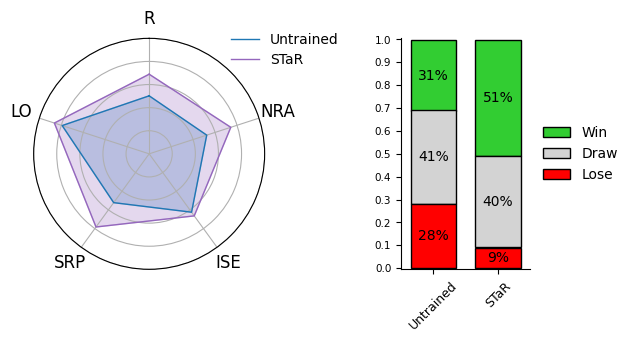

In [ ]:
plot_rps_runs([
    ("RPS-baseline-0", 0, "Untrained", "#1f77b4"),
    ("star-3-0", 2000, "STaR", "#9467bd"),
])

GRPO :
{'ISE': np.float64(-0.6118782198568706),
 'LO': np.float64(1.505635497816358),
 'NRA': np.float64(0.6890816215967913),
 'R': np.float64(1.632421875),
 'SRP': np.float64(0.8419964250345977)}
{'eval/draw_rate': np.float64(0.183984375),
 'eval/loss_rate': np.float64(0.082421875),
 'eval/win_rate': np.float64(0.73359375)}

DPO-perms :
{'ISE': np.float64(-0.5828645773828224),
 'LO': np.float64(1.5240358007884198),
 'NRA': np.float64(0.6512602944449467),
 'R': np.float64(1.6052791262135921),
 'SRP': np.float64(0.873494275201169)}
{'eval/draw_rate': np.float64(0.17930825242718446),
 'eval/loss_rate': np.float64(0.09739077669902912),
 'eval/win_rate': np.float64(0.7233009708737864)}

STaR :
{'ISE': np.float64(-0.5038323709732355),
 'LO': np.float64(1.7254184954523197),
 'NRA': np.float64(0.48637907175273776),
 'R': np.float64(1.37875),
 'SRP': np.float64(0.7828744607805536)}
{'eval/draw_rate': np.float64(0.3975),
 'eval/loss_rate': np.float64(0.09125),
 'eval/win_rate': np.float64(0.511

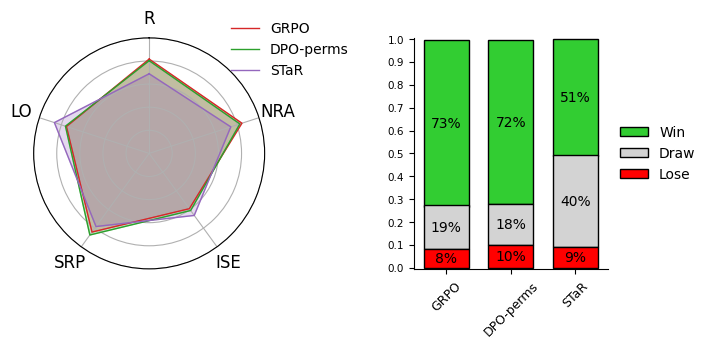

In [25]:
plot_rps_runs([
    ("grpo_final-2", 1000, "GRPO", "#d62728"),
    ("dpo-perms_lr-1e-5-4", 1000, "DPO-perms", "#2ca02c"),
    ("star-3-0", 2000, "STaR", "#9467bd"),
])

# Bertrand Competition

In [16]:
def plot_bertrand_runs(runs):
    fig = plt.figure(figsize=(5, 3))
    ax = fig.add_subplot(1, 1, 1)

    game = "bertrand-competition"
    for i, r in enumerate(runs):
        if len(r) == 3: (run_name, step_threshold, label), color = r, None
        else:            run_name, step_threshold, label , color = r

        general_metrics, game_metrics = get_metrics(game, step_threshold, run_name)
        metrics = general_metrics | game_metrics
        print(label, ':')
        pprint(metrics)
        print()

        spider_plot(normalize(metrics), ax, label=label, color=color)

    ax.legend(loc='center left', bbox_to_anchor=(0.8, 0.95), frameon=False)

    plt.show()

ZeroDivisionError: division by zero

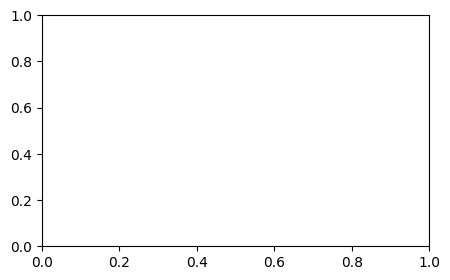

In [20]:
plot_bertrand_runs([
    ("baseline-1", 0, "Untrained", "#1f77b4"),
    ("grpo-debugged-1", 500, "GRPO", "#d62728"),
])

Untrained :
{'ISE': np.float64(-0.5628815112503355),
 'LO': np.float64(1.5835749538663322),
 'NRA': np.float64(0.048268270767392076),
 'R': np.float64(1.0044642857142858),
 'SRP': np.float64(0.5224984558113305)}
{'eval/draw_rate': np.float64(0.40625),
 'eval/loss_rate': np.float64(0.28125),
 'eval/win_rate': np.float64(0.3125)}

DPO-perms :
{'ISE': np.float64(-0.5828645773828224),
 'LO': np.float64(1.5240358007884198),
 'NRA': np.float64(0.6512602944449467),
 'R': np.float64(1.6052791262135921),
 'SRP': np.float64(0.873494275201169)}
{'eval/draw_rate': np.float64(0.17930825242718446),
 'eval/loss_rate': np.float64(0.09739077669902912),
 'eval/win_rate': np.float64(0.7233009708737864)}

DPO-pairs :
{'ISE': np.float64(-0.5532132647426422),
 'LO': np.float64(1.5447001692682385),
 'NRA': np.float64(0.6288495752303211),
 'R': np.float64(1.5634282178217822),
 'SRP': np.float64(0.877182062616112)}
{'eval/draw_rate': np.float64(0.1791460396039604),
 'eval/loss_rate': np.float64(0.1132425742574

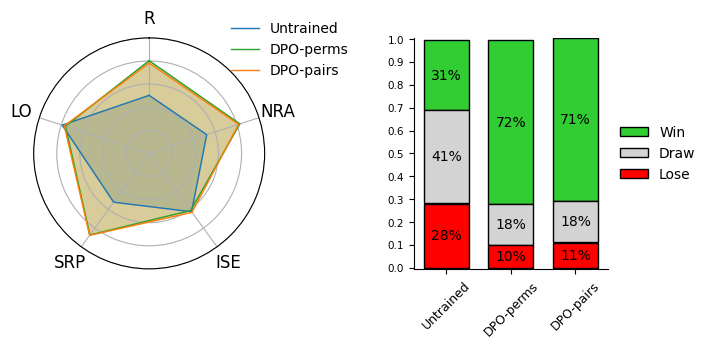

In [ ]:
plot_rps_runs([
    ("RPS-baseline-0", 0, "Untrained", "#1f77b4"),
    ("dpo-perms_lr-1e-5-4", 1000, "DPO-perms", "#2ca02c"),
    ("dpo-pairs_lr-1e-5-0", 1000, "DPO-pairs", "#ff7f0e"),
])

Untrained :
{'ISE': np.float64(-0.5628815112503355),
 'LO': np.float64(1.5835749538663322),
 'NRA': np.float64(0.048268270767392076),
 'R': np.float64(1.0044642857142858),
 'SRP': np.float64(0.5224984558113305)}
{'eval/draw_rate': np.float64(0.40625),
 'eval/loss_rate': np.float64(0.28125),
 'eval/win_rate': np.float64(0.3125)}

STaR :
{'ISE': np.float64(-0.5038323709732355),
 'LO': np.float64(1.7254184954523197),
 'NRA': np.float64(0.48637907175273776),
 'R': np.float64(1.37875),
 'SRP': np.float64(0.7828744607805536)}
{'eval/draw_rate': np.float64(0.3975),
 'eval/loss_rate': np.float64(0.09125),
 'eval/win_rate': np.float64(0.51125)}



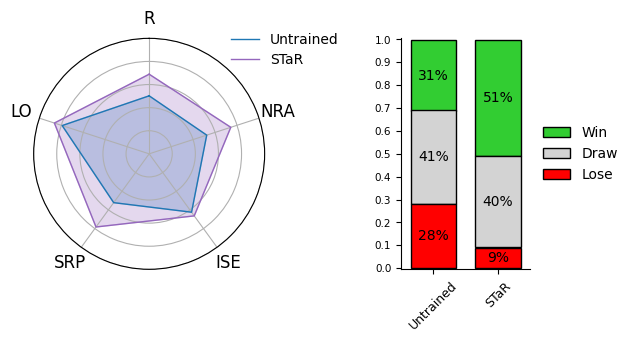

In [ ]:
plot_rps_runs([
    ("RPS-baseline-0", 0, "Untrained", "#1f77b4"),
    ("star-3-0", 2000, "STaR", "#9467bd"),
])

GRPO :
{'ISE': np.float64(-0.6118782198568706),
 'LO': np.float64(1.505635497816358),
 'NRA': np.float64(0.6890816215967913),
 'R': np.float64(1.632421875),
 'SRP': np.float64(0.8419964250345977)}
{'eval/draw_rate': np.float64(0.183984375),
 'eval/loss_rate': np.float64(0.082421875),
 'eval/win_rate': np.float64(0.73359375)}

DPO-perms :
{'ISE': np.float64(-0.5828645773828224),
 'LO': np.float64(1.5240358007884198),
 'NRA': np.float64(0.6512602944449467),
 'R': np.float64(1.6052791262135921),
 'SRP': np.float64(0.873494275201169)}
{'eval/draw_rate': np.float64(0.17930825242718446),
 'eval/loss_rate': np.float64(0.09739077669902912),
 'eval/win_rate': np.float64(0.7233009708737864)}

STaR :
{'ISE': np.float64(-0.5038323709732355),
 'LO': np.float64(1.7254184954523197),
 'NRA': np.float64(0.48637907175273776),
 'R': np.float64(1.37875),
 'SRP': np.float64(0.7828744607805536)}
{'eval/draw_rate': np.float64(0.3975),
 'eval/loss_rate': np.float64(0.09125),
 'eval/win_rate': np.float64(0.511

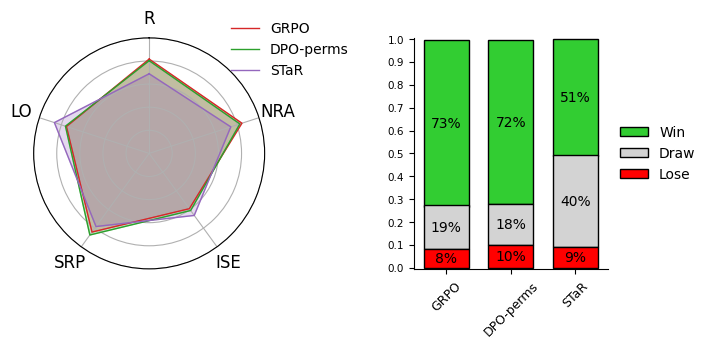

In [ ]:
plot_rps_runs([
    ("grpo_final-2", 1000, "GRPO", "#d62728"),
    ("dpo-perms_lr-1e-5-4", 1000, "DPO-perms", "#2ca02c"),
    ("star-3-0", 2000, "STaR", "#9467bd"),
])